In [46]:
import word2vec as w2v
import pandas as pd
# import cupy as np
import numpy as np
import matplotlib.pyplot as plt
from scipy.spatial.distance import cosine
from sklearn.decomposition import PCA
import tensorflow as tf
from tensorflow import keras
import re
import os
import random
import warnings
import datetime
import time

os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'
warnings.filterwarnings("ignore")
# tf.debugging.set_log_device_placement(True)
print(tf.__version__)
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

2.10.0
Num GPUs Available:  1


In [47]:
def FilterDataset(dataset, size) :
	filtered = dataset.copy().head(size)
	for text, idx in zip(filtered.content.values, filtered.index.values) :
		tmp = np.array([word for word in re.sub('\W', ' ', re.sub("[’']", "", re.sub("http[\S]+", "URL", text, flags=re.U), flags=re.U), flags=re.U).lower().split()])
		if len(tmp) <= 1 :
			filtered.loc[idx]
			filtered = filtered.drop(idx)
	return filtered

In [48]:
# trumpTweets_DF = pd.read_csv("realdonaldtrump.csv", sep=",")

In [49]:
# plt.xscale('log')
# plt.yscale('log')
# plt.plot(trumpTweets_DF.retweets, 'o', label="retweets")
# plt.plot(trumpTweets_DF.favorites, 'o', label="likes")
# plt.legend()

In [50]:
def LoadDataset(version, size, vec_size):
	trumpTweets_DF = pd.read_csv("realerdonaldertrumper.csv", sep=",")

	result_data = w2v.Word2Vec()
	result_data.loadFromFile("./models_" + str(version) + "/calculated_model_" + str(size) + "_" + str(vec_size) + ".txt")
	result = result_data.words_df
	# print(1- cosine(result.loc[result["word"].isin(["donald"])]["vector"][0], result.loc[result["word"].isin(["trump"])]["vector"][0]))
	# print(result.shape)
	filtered_df = FilterDataset(trumpTweets_DF, size)

	list_of_tweets = w2v.stripPunctuation(filtered_df.content[:size])

	filtered_df["content_vectors"] = [np.vstack(result.loc[result.word.isin(tweet)].vector.values) for tweet in list_of_tweets]
	longest_tweet = 0
	for tweet in filtered_df["content_vectors"] :
		if tweet.shape[0] > longest_tweet :
			longest_tweet = tweet.shape[0]
	for i, tweet in zip(filtered_df.index, filtered_df["content_vectors"]) :
		filtered_df["content_vectors"][i] = np.pad(tweet, [(0, longest_tweet - tweet.shape[0]), (0,0)])
	input_mtx = np.stack(filtered_df["content_vectors"])
	input_y = filtered_df.retweets.values
	# input_y = np.c_[input_y, filtered_df.favorites.values]
	# input_y = input_y.mean(axis=1)
	print(input_y.shape)
	
	input_y = np.log(input_y)
	flat_X = input_mtx.mean(axis=1)
	flat_X = np.c_[flat_X, np.array([tweet.shape[0] / longest_tweet for tweet in list_of_tweets])]
	timestamp = []
	datetime_frame = [np.inf, -np.inf]
	for date in filtered_df.date.values :
		timestamp.append(time.mktime(datetime.datetime.strptime(date, "%Y-%m-%d %H:%M:%S").timetuple()))
		if timestamp[-1] < datetime_frame[0]:
			datetime_frame[0] = timestamp[-1]
		elif timestamp[-1] > datetime_frame[1]:
			datetime_frame[1] = timestamp[-1]

	flat_X = np.c_[flat_X, np.array([(date - datetime_frame[0]) / datetime_frame[1] for date in timestamp])]
	flat_X = np.c_[flat_X, filtered_df.haslink.values]
	
	return flat_X, input_y

In [51]:
def train_test_split(input_mtx, input_y, test_size):
	random.seed(1234123)
	test_split = random.choices([i for i in range(input_mtx.shape[0])], k= int(np.round(test_size * input_mtx.shape[0])))
	train_split = [i for i in range(input_mtx.shape[0]) if i not in test_split]
	return train_split, test_split

In [52]:
def score(y_true, y_pred) :
	sum_squares_residuals = np.array((((y_true - y_pred) * 1e+4) ** 2), dtype=np.int64).sum()
	print(sum_squares_residuals)
	sum_squares = np.array((((y_true - np.array(y_true * 1e+6, dtype = np.int64).sum() * 1e-6 / y_true.shape[0]) * 1e+4) ** 2), dtype=np.int64).sum()
	print(sum_squares)
	R2 = 1 - sum_squares_residuals / sum_squares
	return np.round(R2 * 100, 2)

In [53]:
# def score2(y_true, y_pred) :
# 	sum_squares_residuals = (((y_true - y_pred)) ** 2).sum()
# 	print(sum_squares_residuals)
# 	sum_squares = (((y_true - y_true.mean())) ** 2).sum()
# 	print(sum_squares)
# 	R2 = 1 - sum_squares_residuals / sum_squares
# 	return np.round(R2 * 100, 2)

In [54]:
def calculateModel(input_mtx, input_y, train_split, test_split, batch_proc, max_layer, layer_step, verbose) :
	tf.keras.utils.set_random_seed(0)

	print(input_mtx.shape[1:])
	retweets_model = keras.Sequential()
	retweets_model.add(keras.Input(shape=input_mtx.shape[1:]))
	# retweets_model.add(keras.layers.Flatten())
	retweets_model.add(keras.layers.Dense(max_layer, activation="linear"))
	for neuron_size in range(max_layer -1, 1, -layer_step):
		retweets_model.add(keras.layers.Dense(neuron_size, activation="linear"))
	retweets_model.add(keras.layers.Dense(1, activation="linear"))
	retweets_model.compile(loss="msle", optimizer=tf.optimizers.Adam(learning_rate=0.0001), metrics=['mae', 'mse', 'msle', 'poisson'])

	with tf.device('/GPU:0') :
		history = retweets_model.fit(input_mtx[train_split], input_y[train_split], validation_split=0.2, verbose=verbose, epochs=100, batch_size=int(batch_proc * input_mtx.shape[0]), shuffle=True)
	R2_train = score(input_y[train_split].reshape(-1,1), retweets_model.predict(input_mtx[train_split]))
	R2_test = score(input_y[test_split].reshape(-1,1), retweets_model.predict(input_mtx[test_split]))
	return R2_train, R2_test, history, retweets_model

In [55]:
def plotR2(r2_list) :
	plt.figure(figsize=(15,10))
	plt.plot([scores[0] for scores in r2_list], label="train")
	plt.plot([scores[1] for scores in r2_list], label="test")
	for i, scores in enumerate(r2_list) :
		plt.annotate(scores[0], [i, scores[0]])
		plt.annotate(scores[1], [i, scores[1]])
	plt.legend()
	plt.show()

In [56]:
# X, Y = LoadDataset(1000, 500)
# train_split, test_split = train_test_split(X,Y, 0.2)

In [57]:
def parallelCalcModel(layers_range) :
	

In [58]:
r2_list = []
for layer in range(70, 80, 1):
	X, Y = LoadDataset("v2", 1000, 500)
	train_split, test_split = train_test_split(X,Y, 0.2)
	result = calculateModel(X, Y, train_split, test_split, 0.2, layer, 1, verbose=0)
	history = result[2]
	r2_list.append(result[:2])

(1000,)
(503,)


2024-06-15 23:45:08.977033: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2024-06-15 23:45:09.721103: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:306] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2024-06-15 23:45:09.721204: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:272] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 11923 MB memory) -> physical PluggableDevice (device: 0, name: DML, pci bus id: <undefined>)
2024-06-15 23:45:10.330700: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2024-06-15 23:45:10.522922: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:306] Could not identify NUMA node of platform GPU ID 0, defaulting to

 8/26 [========>.....................] - ETA: 0s

2024-06-15 23:45:26.629975: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


26/26 [==============================] - 1s 8ms/step
61699343250
133835006530
7/7 [==============================] - 0s 9ms/step
21589438992
30598975805


2024-06-15 23:45:26.961027: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:306] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2024-06-15 23:45:26.961115: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:272] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 11923 MB memory) -> physical PluggableDevice (device: 0, name: DML, pci bus id: <undefined>)
2024-06-15 23:45:26.978136: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:306] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2024-06-15 23:45:26.978232: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:272] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 11923 MB memory) -> physical PluggableDevice (device: 0, name: 

(1000,)
(503,)


2024-06-15 23:45:36.337726: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2024-06-15 23:45:37.123317: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:306] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2024-06-15 23:45:37.123426: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:272] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 11923 MB memory) -> physical PluggableDevice (device: 0, name: DML, pci bus id: <undefined>)
2024-06-15 23:45:37.726866: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2024-06-15 23:45:37.896901: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:306] Could not identify NUMA node of platform GPU ID 0, defaulting to

26/26 [==============================] - 1s 11ms/step
59802336613
133835006530
1/7 [===>..........................] - ETA: 0s

2024-06-15 23:45:58.343813: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:306] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2024-06-15 23:45:58.343924: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:272] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 11923 MB memory) -> physical PluggableDevice (device: 0, name: DML, pci bus id: <undefined>)
2024-06-15 23:45:58.368902: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:306] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2024-06-15 23:45:58.369007: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:272] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 11923 MB memory) -> physical PluggableDevice (device: 0, name: 

7/7 [==============================] - 0s 13ms/step
21228800946
30598975805


2024-06-15 23:45:58.585626: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:306] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2024-06-15 23:45:58.585735: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:272] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 11923 MB memory) -> physical PluggableDevice (device: 0, name: DML, pci bus id: <undefined>)


(1000,)
(503,)


2024-06-15 23:46:09.409110: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2024-06-15 23:46:10.130634: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:306] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2024-06-15 23:46:10.130720: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:272] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 11923 MB memory) -> physical PluggableDevice (device: 0, name: DML, pci bus id: <undefined>)
2024-06-15 23:46:10.690672: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2024-06-15 23:46:10.844251: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:306] Could not identify NUMA node of platform GPU ID 0, defaulting to

26/26 [==============================] - 1s 10ms/step
64090464699
133835006530
1/7 [===>..........................] - ETA: 0s

2024-06-15 23:46:27.811732: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:306] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2024-06-15 23:46:27.811820: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:272] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 11923 MB memory) -> physical PluggableDevice (device: 0, name: DML, pci bus id: <undefined>)
2024-06-15 23:46:27.832028: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:306] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2024-06-15 23:46:27.832109: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:272] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 11923 MB memory) -> physical PluggableDevice (device: 0, name: 

7/7 [==============================] - 0s 12ms/step
21166821703
30598975805


2024-06-15 23:46:28.045142: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:306] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2024-06-15 23:46:28.045253: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:272] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 11923 MB memory) -> physical PluggableDevice (device: 0, name: DML, pci bus id: <undefined>)


(1000,)
(503,)


2024-06-15 23:46:40.739808: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2024-06-15 23:46:41.535196: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:306] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2024-06-15 23:46:41.535318: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:272] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 11923 MB memory) -> physical PluggableDevice (device: 0, name: DML, pci bus id: <undefined>)
2024-06-15 23:46:42.763011: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2024-06-15 23:46:43.366598: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:306] Could not identify NUMA node of platform GPU ID 0, defaulting to

 1/26 [>.............................] - ETA: 11s

2024-06-15 23:47:02.173753: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


26/26 [==============================] - 1s 10ms/step
60084973594
133835006530
7/7 [==============================] - 0s 12ms/step


2024-06-15 23:47:02.571053: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:306] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2024-06-15 23:47:02.571146: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:272] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 11923 MB memory) -> physical PluggableDevice (device: 0, name: DML, pci bus id: <undefined>)
2024-06-15 23:47:02.591379: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:306] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2024-06-15 23:47:02.591475: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:272] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 11923 MB memory) -> physical PluggableDevice (device: 0, name: 

20288909123
30598975805


2024-06-15 23:47:02.784385: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:306] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2024-06-15 23:47:02.784514: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:272] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 11923 MB memory) -> physical PluggableDevice (device: 0, name: DML, pci bus id: <undefined>)


(1000,)
(503,)


2024-06-15 23:47:13.133454: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2024-06-15 23:47:13.957519: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:306] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2024-06-15 23:47:13.957623: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:272] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 11923 MB memory) -> physical PluggableDevice (device: 0, name: DML, pci bus id: <undefined>)
2024-06-15 23:47:14.537499: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2024-06-15 23:47:14.697116: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:306] Could not identify NUMA node of platform GPU ID 0, defaulting to

 8/26 [========>.....................] - ETA: 0s

2024-06-15 23:47:31.712805: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


26/26 [==============================] - 1s 7ms/step
61311916033
133835006530
7/7 [==============================] - 0s 9ms/step
22787146819
30598975805


2024-06-15 23:47:32.031199: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:306] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2024-06-15 23:47:32.031267: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:272] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 11923 MB memory) -> physical PluggableDevice (device: 0, name: DML, pci bus id: <undefined>)
2024-06-15 23:47:32.048953: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:306] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2024-06-15 23:47:32.049033: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:272] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 11923 MB memory) -> physical PluggableDevice (device: 0, name: 

(1000,)
(503,)


2024-06-15 23:47:42.026003: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2024-06-15 23:47:42.635228: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:306] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2024-06-15 23:47:42.635304: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:272] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 11923 MB memory) -> physical PluggableDevice (device: 0, name: DML, pci bus id: <undefined>)
2024-06-15 23:47:43.217716: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2024-06-15 23:47:43.382037: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:306] Could not identify NUMA node of platform GPU ID 0, defaulting to

 1/26 [>.............................] - ETA: 13s

2024-06-15 23:48:08.024682: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


26/26 [==============================] - 1s 9ms/step
61741947000
133835006530
7/7 [==============================] - 0s 9ms/step


2024-06-15 23:48:08.438704: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:306] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2024-06-15 23:48:08.438813: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:272] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 11923 MB memory) -> physical PluggableDevice (device: 0, name: DML, pci bus id: <undefined>)
2024-06-15 23:48:08.461656: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:306] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2024-06-15 23:48:08.461738: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:272] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 11923 MB memory) -> physical PluggableDevice (device: 0, name: 

20572302577
30598975805
(1000,)
(503,)


2024-06-15 23:48:18.661480: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2024-06-15 23:48:19.416024: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:306] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2024-06-15 23:48:19.416109: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:272] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 11923 MB memory) -> physical PluggableDevice (device: 0, name: DML, pci bus id: <undefined>)
2024-06-15 23:48:20.032438: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2024-06-15 23:48:20.286627: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:306] Could not identify NUMA node of platform GPU ID 0, defaulting to

 1/26 [>.............................] - ETA: 10s

2024-06-15 23:48:37.336220: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


26/26 [==============================] - 1s 9ms/step
61229671411
133835006530
1/7 [===>..........................] - ETA: 0s

2024-06-15 23:48:37.727394: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:306] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2024-06-15 23:48:37.727520: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:272] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 11923 MB memory) -> physical PluggableDevice (device: 0, name: DML, pci bus id: <undefined>)
2024-06-15 23:48:37.751400: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:306] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2024-06-15 23:48:37.751542: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:272] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 11923 MB memory) -> physical PluggableDevice (device: 0, name: 

7/7 [==============================] - 0s 10ms/step
21463847073
30598975805


2024-06-15 23:48:37.941572: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:306] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2024-06-15 23:48:37.941655: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:272] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 11923 MB memory) -> physical PluggableDevice (device: 0, name: DML, pci bus id: <undefined>)


(1000,)
(503,)


2024-06-15 23:48:50.739837: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2024-06-15 23:48:51.986936: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:306] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2024-06-15 23:48:51.987047: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:272] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 11923 MB memory) -> physical PluggableDevice (device: 0, name: DML, pci bus id: <undefined>)
2024-06-15 23:48:52.782470: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2024-06-15 23:48:52.985763: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:306] Could not identify NUMA node of platform GPU ID 0, defaulting to

 1/26 [>.............................] - ETA: 14s

2024-06-15 23:49:15.894624: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


26/26 [==============================] - 1s 9ms/step
64564522001
133835006530
1/7 [===>..........................] - ETA: 0s

2024-06-15 23:49:16.272525: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:306] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2024-06-15 23:49:16.272616: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:272] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 11923 MB memory) -> physical PluggableDevice (device: 0, name: DML, pci bus id: <undefined>)
2024-06-15 23:49:16.301436: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:306] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2024-06-15 23:49:16.301537: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:272] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 11923 MB memory) -> physical PluggableDevice (device: 0, name: 

7/7 [==============================] - 0s 11ms/step
21949056387
30598975805


2024-06-15 23:49:16.504552: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:306] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2024-06-15 23:49:16.504679: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:272] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 11923 MB memory) -> physical PluggableDevice (device: 0, name: DML, pci bus id: <undefined>)


(1000,)
(503,)


2024-06-15 23:49:27.134250: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2024-06-15 23:49:28.239189: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:306] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2024-06-15 23:49:28.239302: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:272] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 11923 MB memory) -> physical PluggableDevice (device: 0, name: DML, pci bus id: <undefined>)
2024-06-15 23:49:28.938254: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2024-06-15 23:49:29.136118: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:306] Could not identify NUMA node of platform GPU ID 0, defaulting to

 1/26 [>.............................] - ETA: 11s

2024-06-15 23:49:48.408573: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


26/26 [==============================] - 1s 8ms/step
59868246767
133835006530
7/7 [==============================] - 0s 9ms/step
22366451312
30598975805


2024-06-15 23:49:48.803289: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:306] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2024-06-15 23:49:48.803395: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:272] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 11923 MB memory) -> physical PluggableDevice (device: 0, name: DML, pci bus id: <undefined>)
2024-06-15 23:49:48.831715: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:306] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2024-06-15 23:49:48.831871: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:272] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 11923 MB memory) -> physical PluggableDevice (device: 0, name: 

(1000,)
(503,)


2024-06-15 23:49:58.057418: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2024-06-15 23:49:58.874959: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:306] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2024-06-15 23:49:58.875072: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:272] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 11923 MB memory) -> physical PluggableDevice (device: 0, name: DML, pci bus id: <undefined>)
2024-06-15 23:49:59.471206: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2024-06-15 23:49:59.633965: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:306] Could not identify NUMA node of platform GPU ID 0, defaulting to

 9/26 [=========>....................] - ETA: 0s 

2024-06-15 23:50:18.053401: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


26/26 [==============================] - 1s 7ms/step
58093020637
133835006530
1/7 [===>..........................] - ETA: 0s

2024-06-15 23:50:18.387434: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:306] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2024-06-15 23:50:18.387511: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:272] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 11923 MB memory) -> physical PluggableDevice (device: 0, name: DML, pci bus id: <undefined>)
2024-06-15 23:50:18.404986: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:306] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2024-06-15 23:50:18.405085: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:272] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 11923 MB memory) -> physical PluggableDevice (device: 0, name: 

7/7 [==============================] - 0s 10ms/step
23571801890
30598975805


2024-06-15 23:50:18.629084: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:306] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2024-06-15 23:50:18.629180: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:272] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 11923 MB memory) -> physical PluggableDevice (device: 0, name: DML, pci bus id: <undefined>)


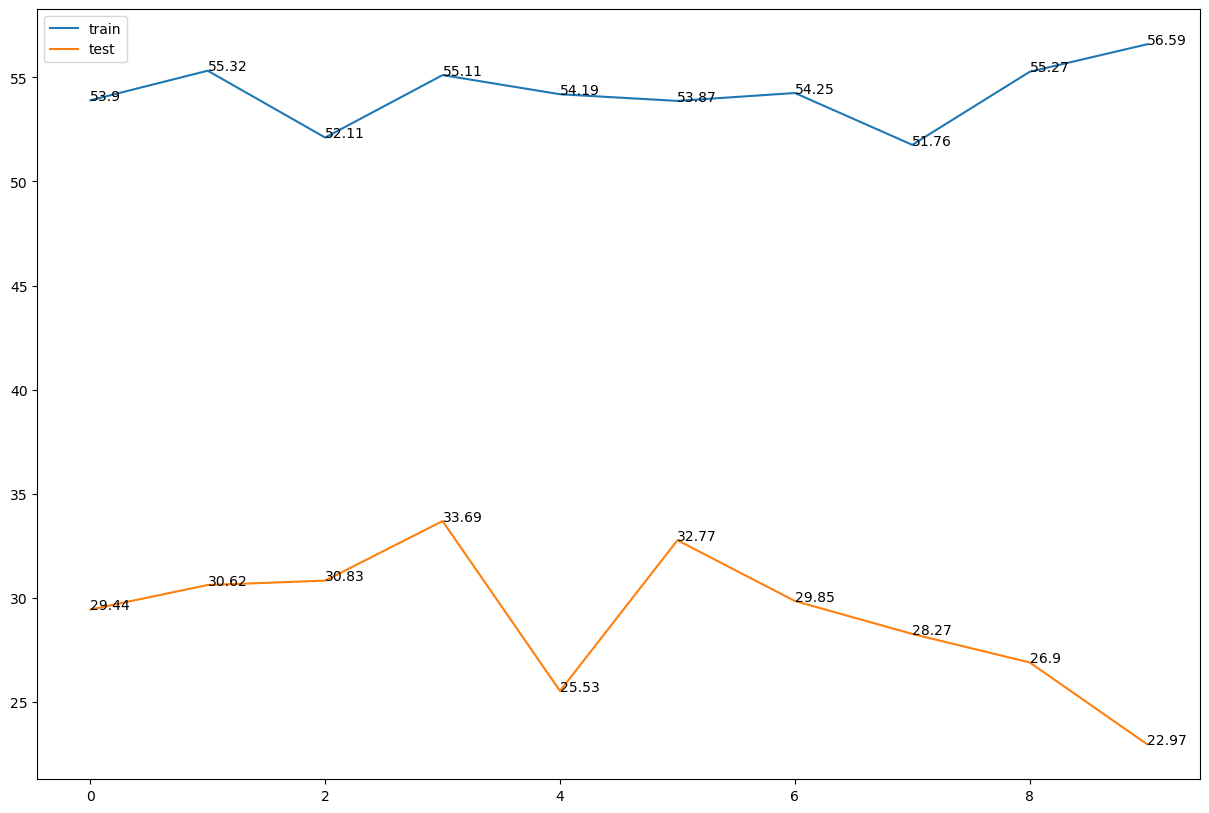

In [59]:
plotR2(r2_list)


In [60]:

# for vec_size in [100,200,400,500] :
# 	X, Y = LoadDataset(1000, vec_size)
# 	train_split, test_split = train_test_split(X,Y, 0.2)
# 	r2_list = []
# 	for batch_proc in np.arange(0.1,1, 0.1) :
# 		print("calculating for",batch_proc)
# 		r2_list.append(calculateModel(X,Y,train_split,test_split,batch_proc))
# 		plotR2(r2_list)

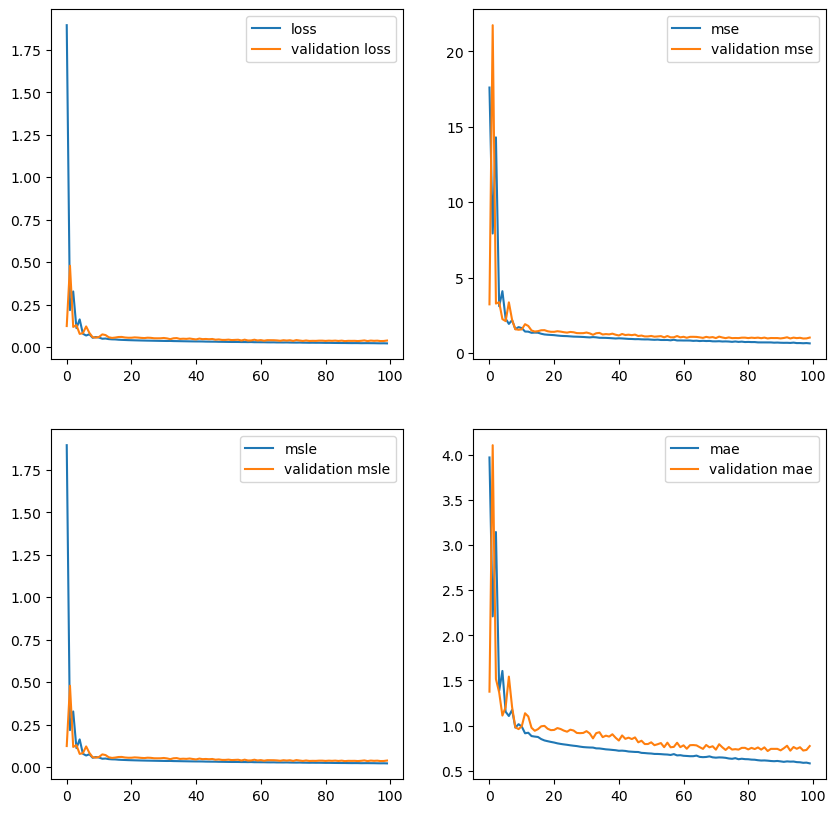

In [61]:
plt.figure(figsize=[10,10])
plt.subplot(2,2,1)
plt.plot(history.history['loss'], label = 'loss')
plt.plot(history.history['val_loss'], label = 'validation loss')
plt.legend()
plt.subplot(2,2,2)
plt.plot(history.history['mse'], label = 'mse')
plt.plot(history.history['val_mse'], label = 'validation mse')
plt.legend()
plt.subplot(2,2,3)
plt.plot(history.history['msle'], label = 'msle')
plt.plot(history.history['val_msle'], label = 'validation msle')
plt.legend()
plt.subplot(2,2,4)
plt.plot(history.history['mae'], label = 'mae')
plt.plot(history.history['val_mae'], label = 'validation mae')
plt.legend()
plt.show()


7/7 [==============================] - 0s 10ms/step


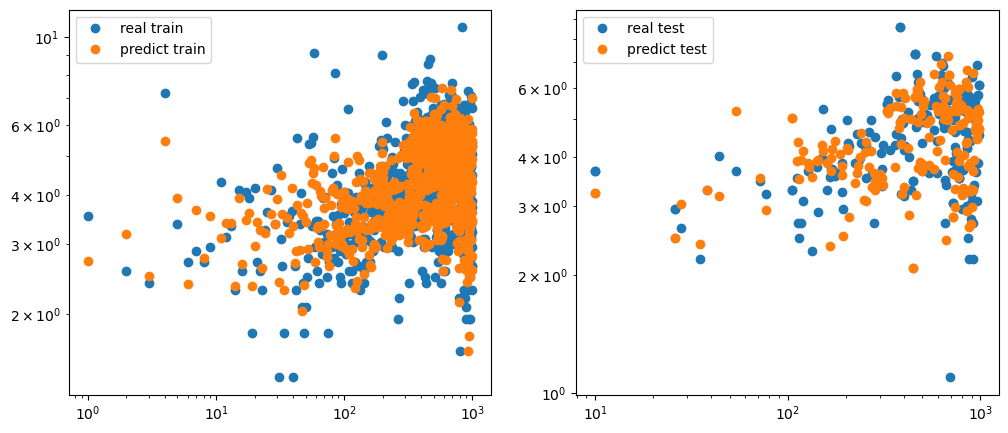

In [62]:
plt.figure(figsize=[12,5])
plt.subplot(1,2,1)
plt.xscale('log')
plt.yscale('log')
# plt.plot(wordy_train.index, wordy_train.values, 'o', label="real train")
# plt.plot(wordy_train.index, retweets_model.predict(wordX_train), 'o', label="predict train")
plt.plot(train_split, Y[train_split], 'o', label="real train")
plt.plot(train_split, result[3].predict(X[train_split]), 'o', label="predict train")

plt.legend()
plt.subplot(1,2,2)
plt.xscale('log')
plt.yscale('log')
plt.plot(test_split, Y[test_split], 'o', label="real test")
plt.plot(test_split, result[3].predict(X[test_split]), 'o', label="predict test")
plt.legend()


In [63]:
# R2_train = score(input_y[train_split].reshape(-1,1), retweets_model.predict(input_mtx[train_split]))
# print("R^2 Score train: %3.2f" % R2_train + "%")
# R2_test = score(input_y[test_split].reshape(-1,1), retweets_model.predict(input_mtx[test_split]))
# print("R^2 Score test: %3.2f" % R2_test + "%")
# msle_score = keras.metrics.MeanSquaredLogarithmicError()
# msle_score.update_state(input_y[train_split].reshape(-1,1),retweets_model.predict(input_mtx[train_split]))
# print("MSLE Score train:", msle_score.result())
# msle_score = keras.metrics.MeanSquaredLogarithmicError()
# msle_score.update_state(input_y[test_split].reshape(-1,1),retweets_model.predict(input_mtx[test_split]))
# print("MSLE Score test:", msle_score.result())

In [64]:
# pred_test = retweets_model.predict(input_mtx[test_split])
# for i in range(input_y[test_split].shape[0]) :
#   print(np.round(np.exp(input_y[test_split][i])), np.round(np.exp(pred_test[i])))

In [65]:
# pred_test = retweets_model.predict(wordX_test)
# for i in range(wordy_test.shape[0]) :
#   print(np.round(wordy_test.values[i]), np.round(pred_test[i]))